## Working with the "Condition Monitoring of Hydraulic Systems" dataset

### Imports

In [1]:
import math as m
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from numpy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import BaggingClassifier
from sklearn.tree     import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier

In [2]:
from platform import python_version

print(python_version())

3.8.5


### Read in and plotting of target values

In [43]:
# Load in the target variables as a Pandas DataFrame
colnam = ['cooler_condition', 'valve_condition', 'internal_pump_leak', 'hydraulic_accumulator', 'stable_flag']

# whitespace separators for target condition values since there are no other separators
target = pd.read_csv('profile.txt',delim_whitespace=True,header=None,names=colnam)

# First 10 lines
target.head(10)

,cooler_condition,valve_condition,internal_pump_leak,hydraulic_accumulator,stable_flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1
5,3,100,0,130,1
6,3,100,0,130,1
7,3,100,0,130,1
8,3,100,0,130,1
9,3,100,0,130,1


In [44]:
# check for potential missing values in the target
print(target.isna().sum())

cooler_condition         0
valve_condition          0
internal_pump_leak       0
hydraulic_accumulator    0
stable_flag              0
dtype: int64


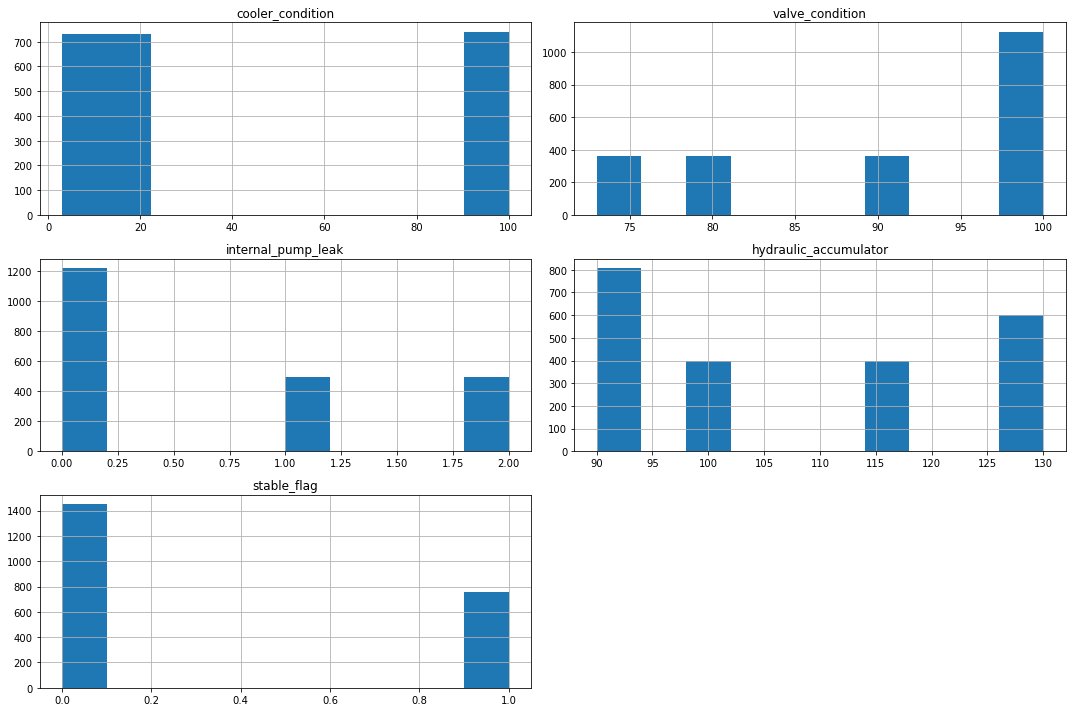

In [45]:
# plotting target data to see overall condition distribution through a histogram
# most of the runs condition were stable according to the stable flags
target.hist()
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 7.5]
plt.show()

C:\Users\hei\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cooler_condition', ylabel='Density'>

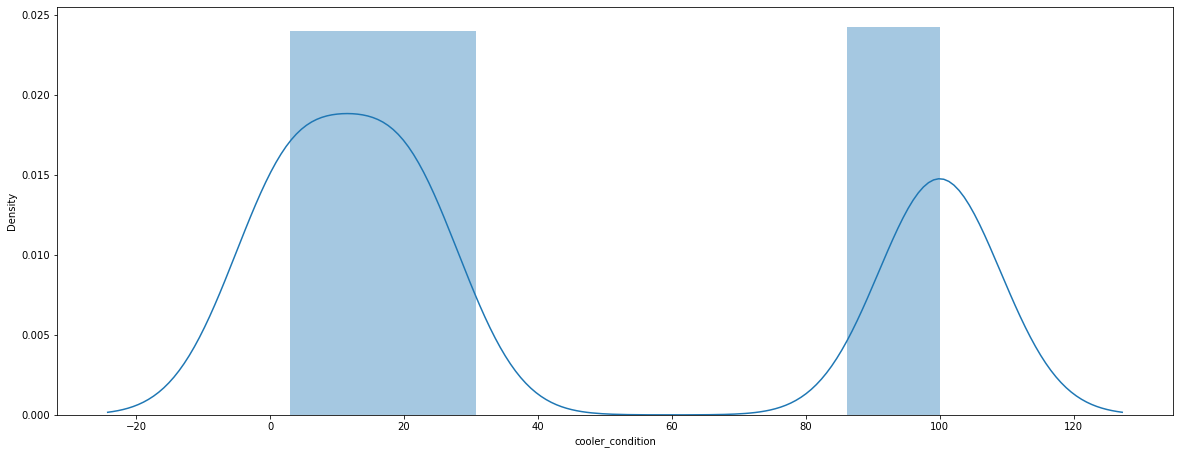

In [46]:
# seaborn displot represents the cooler condition better
sns.distplot(target[colnam[0]])

### Read in, preprocessing and plotting of dataset

In [7]:
# Pressure read in
pressure_1 = pd.read_csv('PS1.txt',delim_whitespace=True,header=None)
pressure_2 = pd.read_csv('PS2.txt',delim_whitespace=True,header=None)
pressure_3 = pd.read_csv('PS3.txt',delim_whitespace=True,header=None)
pressure_4 = pd.read_csv('PS4.txt',delim_whitespace=True,header=None)
pressure_5 = pd.read_csv('PS5.txt',delim_whitespace=True,header=None)
pressure_6 = pd.read_csv('PS6.txt',delim_whitespace=True,header=None)

In [8]:
# Load the rest
motor_power = pd.read_csv('EPS1.txt',delim_whitespace=True,header=None)
vibration = pd.read_csv('VS1.txt',delim_whitespace=True,header=None)
cool_eff = pd.read_csv('CE.txt',delim_whitespace=True,header=None)
cool_pwr = pd.read_csv('CP.txt',delim_whitespace=True,header=None)
effcy_fctr = pd.read_csv('SE.txt',delim_whitespace=True,header=None)

In [9]:
# Temperature
temperature_1 = pd.read_csv('TS1.txt',delim_whitespace=True,header=None)
temperature_2 = pd.read_csv('TS2.txt',delim_whitespace=True,header=None)
temperature_3 = pd.read_csv('TS3.txt',delim_whitespace=True,header=None)
temperature_4 = pd.read_csv('TS4.txt',delim_whitespace=True,header=None)

In [10]:
# Volume flow
volflow_1 = pd.read_csv('FS1.txt',delim_whitespace=True,header=None)
volflow_2 = pd.read_csv('FS2.txt',delim_whitespace=True,header=None)

In [11]:
pressure_1

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,151.47,151.45,151.52,151.27,150.80,150.69,153.89,154.67,152.88,153.82,...,151.16,151.19,151.25,151.16,151.10,151.16,151.14,151.10,151.21,151.19
1,151.11,151.12,151.16,150.92,150.70,150.62,152.40,153.21,152.81,153.53,...,150.82,150.82,150.86,150.80,150.73,150.79,150.84,150.79,150.80,150.86
2,150.81,150.79,150.84,150.65,150.35,150.23,152.03,152.81,152.44,153.27,...,150.49,150.44,150.47,150.46,150.38,150.47,150.50,150.43,150.54,150.62
3,150.48,150.47,150.52,150.31,150.04,149.98,151.63,152.48,152.24,152.94,...,150.34,150.30,150.28,150.38,150.41,150.33,150.31,150.31,150.25,150.28
4,150.41,150.35,150.24,150.12,149.87,149.71,151.64,152.37,151.78,152.68,...,150.31,150.20,150.17,150.28,150.31,150.25,150.27,150.22,150.13,150.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,151.70,151.83,151.90,151.75,151.62,151.63,153.78,154.73,153.83,154.43,...,151.84,151.75,151.67,151.76,151.81,151.78,151.78,151.83,151.84,151.86
2201,151.90,151.83,151.81,151.77,151.65,151.63,153.97,154.84,153.67,154.37,...,151.81,151.81,151.84,151.83,151.79,151.87,151.87,151.75,151.77,151.78
2202,151.73,151.78,151.84,151.62,151.46,151.49,153.91,154.88,153.69,154.24,...,151.73,151.66,151.73,151.71,151.68,151.79,151.84,151.73,151.73,151.83
2203,151.77,151.77,151.75,151.56,151.47,151.57,154.09,154.80,153.45,154.21,...,151.75,151.71,151.68,151.71,151.73,151.75,151.71,151.68,151.71,151.78


In [12]:
#data_frames = [pressure1, pressure_2, pressure_3]

In [13]:
#average the cycle data

def mean_conversion(df):
    df1 = pd.DataFrame()
    df1 = df.mean(axis = 1)
    return df1

In [14]:
# Without taking the mean we get a pandas dataframe with a whopping 2205 rows and 43680 columns, 
# which is painful to work with. We could do feature extraction or dimensionality reduction but this is simple and effective

pressure_1 = pd.DataFrame(pressure_1.mean(axis = 1))
pressure_2 = pd.DataFrame(pressure_2.mean(axis = 1))
pressure_3 = pd.DataFrame(pressure_3.mean(axis = 1))
pressure_4 = pd.DataFrame(pressure_4.mean(axis = 1))
pressure_5 = pd.DataFrame(pressure_5.mean(axis = 1))
pressure_6 = pd.DataFrame(pressure_6.mean(axis = 1))

motor_power = pd.DataFrame(motor_power.mean(axis = 1))
vibration = pd.DataFrame(vibration.mean(axis = 1))
cool_eff = pd.DataFrame(cool_eff.mean(axis = 1))
cool_pwr = pd.DataFrame(cool_pwr.mean(axis = 1))
effcy_fctr = pd.DataFrame(effcy_fctr.mean(axis = 1))

temperature_1 = pd.DataFrame(temperature_1.mean(axis = 1))
temperature_2 = pd.DataFrame(temperature_2.mean(axis = 1))
temperature_3 = pd.DataFrame(temperature_3.mean(axis = 1))
temperature_4 = pd.DataFrame(temperature_4.mean(axis = 1))

volflow_1 = pd.DataFrame(volflow_1.mean(axis = 1))
volflow_2 = pd.DataFrame(volflow_2.mean(axis = 1))

In [15]:
volflow_2

,0
0,10.304592
1,10.403098
2,10.366250
3,10.302678
4,10.237750
...,...
2200,10.184515
2201,10.177767
2202,10.176172
2203,10.178353


In [16]:
# Merge them all together and flip on the side
df_full = pd.concat([pressure_1, pressure_2, pressure_3, pressure_4, pressure_5, pressure_6, 
                     temperature_1, temperature_2, temperature_3, temperature_4,
                     motor_power, vibration, cool_eff, cool_pwr, effcy_fctr,
                     volflow_1, volflow_2], axis=1)

# add column names
df_full.columns =['PS1','PS2','PS3','PS4','PS5','PS6','TS1','TS2','TS3','TS4','EPS1','VS1',
                  'CE','CP','SE','FS1','FS2']

In [17]:
df_full

,PS1,PS2,PS3,PS4,PS5,PS6,TS1,TS2,TS3,TS4,EPS1,VS1,CE,CP,SE,FS1,FS2
0,160.673492,109.466914,1.991475,0.000000,9.842170,9.728097,35.621983,40.978767,38.471017,31.745250,2538.929167,0.576950,39.601350,1.862750,59.157183,6.709815,10.304592
1,160.603320,109.354890,1.976234,0.000000,9.635142,9.529488,36.676967,41.532767,38.978967,34.493867,2531.498900,0.565850,25.786433,1.255550,59.335617,6.715315,10.403098
2,160.347720,109.158845,1.972224,0.000000,9.530548,9.427949,37.880800,42.442450,39.631950,35.646150,2519.928000,0.576533,22.218233,1.113217,59.543150,6.718522,10.366250
3,160.188088,109.064807,1.946575,0.000000,9.438827,9.337430,38.879050,43.403983,40.403383,36.579467,2511.541633,0.569267,20.459817,1.062150,59.794900,6.720565,10.302678
4,160.000472,108.931434,1.922707,0.000000,9.358762,9.260636,39.803917,44.332750,41.310550,37.427900,2503.449500,0.577367,19.787017,1.070467,59.455267,6.690308,10.237750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,161.227572,109.779581,2.001438,10.202473,9.972037,9.850361,35.313783,40.874800,38.269267,30.404733,2543.911033,0.550833,46.628517,2.160600,59.033100,6.689930,10.184515
2201,161.206070,109.787481,1.998781,10.197919,9.966184,9.844854,35.321600,40.868883,38.268250,30.416233,2543.411333,0.547483,46.689817,2.151450,59.068000,6.692182,10.177767
2202,161.192120,109.756174,1.993436,10.196824,9.964329,9.842628,35.319183,40.875950,38.246367,30.426250,2542.729767,0.545233,46.472300,2.143300,59.132350,6.693277,10.176172
2203,161.208917,109.793884,2.007077,10.198588,9.968232,9.846690,35.324767,40.876067,38.245733,30.414283,2544.046333,0.537017,46.544967,2.148483,58.970800,6.684128,10.178353


In [18]:
df_full.describe()

,PS1,PS2,PS3,PS4,PS5,PS6,TS1,TS2,TS3,TS4,EPS1,VS1,CE,CP,SE,FS1,FS2
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,160.485315,109.379906,1.753227,2.600266,9.163320,9.079363,45.424567,50.365979,47.662121,40.735654,2495.509203,0.613315,31.299077,1.808399,55.287900,6.198549,9.649453
std,4.699425,4.986585,0.251902,4.279355,0.576296,0.549589,7.991933,7.396254,7.451888,8.107878,73.836682,0.060260,11.575330,0.278263,8.960189,1.032883,0.449246
min,155.391547,104.406307,0.840252,0.000000,8.365800,8.321527,35.313783,40.859400,38.245733,30.390800,2361.747267,0.524367,17.555983,1.062150,18.276617,2.018572,8.857513
25%,158.100195,106.962382,1.729733,0.000000,8.547239,8.487167,36.237150,41.864183,39.123183,31.272567,2442.933467,0.555100,20.084650,1.550100,56.270183,6.391670,9.203397
50%,158.960895,107.730169,1.779631,0.000000,9.115781,9.031516,44.836650,49.780583,47.070250,40.429050,2480.926633,0.610183,27.392533,1.739683,58.758150,6.576673,9.692270
75%,161.000735,109.421612,1.932047,3.503266,9.844351,9.729275,54.104317,58.584467,55.694433,49.409500,2548.211467,0.649850,46.677383,2.148483,59.656900,6.657508,10.155008
max,180.922708,131.589089,2.023398,10.207068,9.978510,9.856591,57.899283,61.958467,59.423167,53.060417,2740.641000,0.839067,47.903667,2.840100,60.755300,6.722707,10.403098


In [19]:
# Check for NaN values. Although the files state that there's no missing vallues, a check is always good.
print(df_full.isna().sum())

PS1     0
PS2     0
PS3     0
PS4     0
PS5     0
PS6     0
TS1     0
TS2     0
TS3     0
TS4     0
EPS1    0
VS1     0
CE      0
CP      0
SE      0
FS1     0
FS2     0
dtype: int64


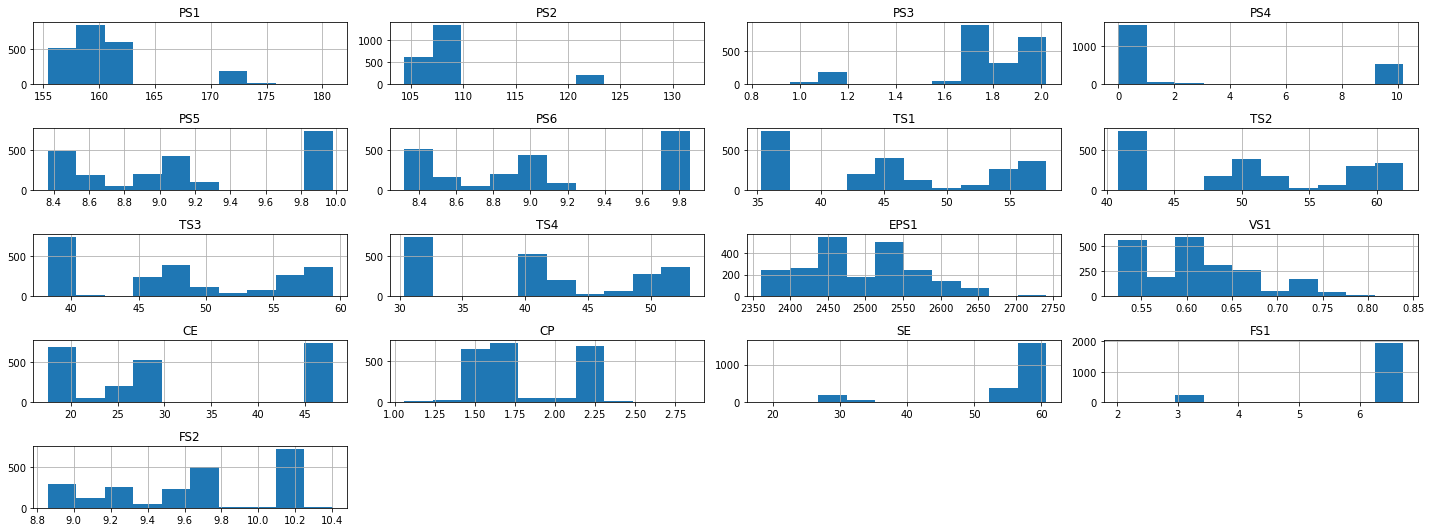

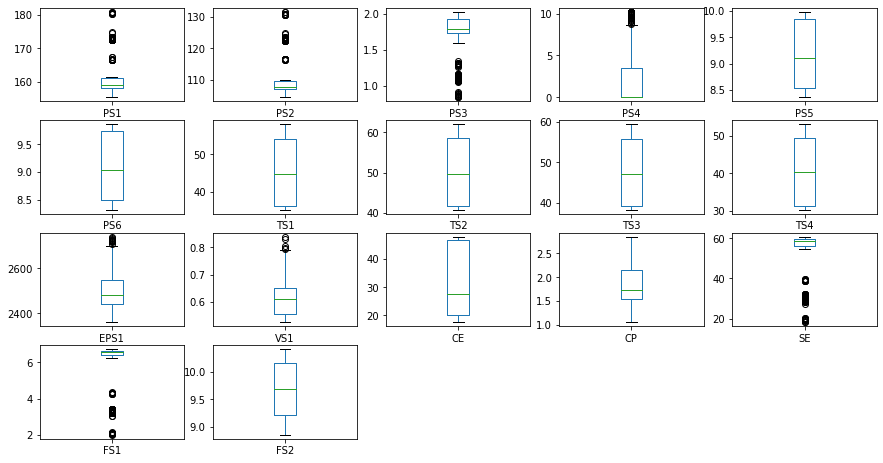

In [20]:
var_numb = 35

# Histograms
df_full.hist()
plt.tight_layout()
plt.rcParams['figure.figsize'] = [15, 11]
plt.show()

plt.rcParams['figure.figsize'] = [15, 10]
# Boxplots
df_full.plot(kind='box', subplots=True, layout=(int(m.sqrt(var_numb)), int(m.sqrt(var_numb))), sharex=False, sharey=False)
plt.show()
# lots of outlier in some of the features
# might be smart removing some feature to train with less outliers

#### Correlation coefficients

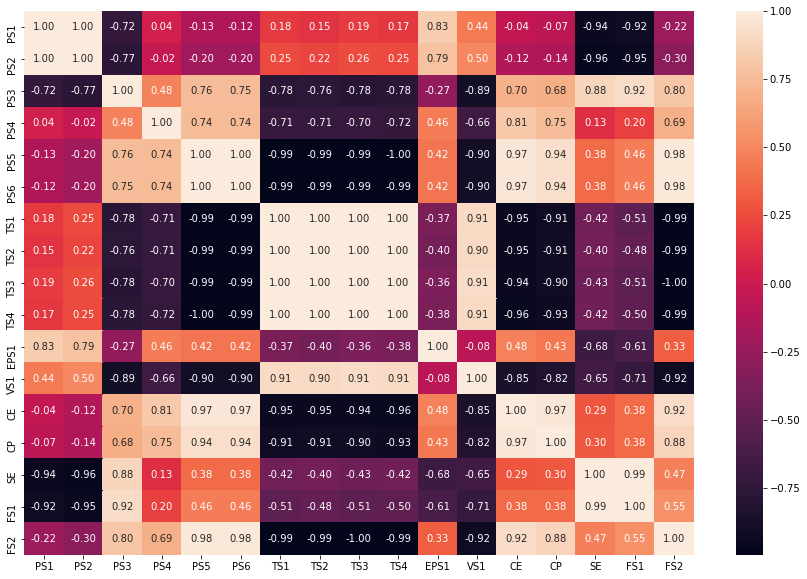

In [21]:
sns.heatmap(df_full.corr(), annot=True, fmt=".2f")
plt.show()

### Model building, scoring and hyperparameter tweaking

#### Simple model testing without tweaking

In [60]:
##### Preprocess
X = df_full
y = target.valve_condition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


# SVC
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
pipe_svc.get_params()

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
print('Test Accuracy: %.3f' % pipe_svc.score(X_test, y_test))

Test Accuracy: 0.567


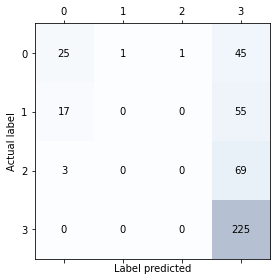

                            precision    recall  f1-score   support

    close to total failure       0.56      0.35      0.43        72
                severe lag       0.00      0.00      0.00        72
                 small lag       0.00      0.00      0.00        72
optimal switching behavior       0.57      1.00      0.73       225

                  accuracy                           0.57       441
                 macro avg       0.28      0.34      0.29       441
              weighted avg       0.38      0.57      0.44       441



In [61]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Label predicted')
plt.ylabel('Actual label')

plt.tight_layout()
plt.show()

# a classification report

target_names = ['close to total failure', 'severe lag', 'small lag', 'optimal switching behavior']
print(classification_report(y_test, y_pred, target_names=target_names))

In [62]:
# Simple training data pipeline
#Random Forest
pipe_rfr = make_pipeline(RandomForestClassifier(random_state=1))


pipe_rfr.fit(X_train, y_train)
y_pred = pipe_rfr.predict(X_test)

print('Test Accuracy: %.3f' % pipe_rfr.score(X_test, y_test))
print("")
pipe_rfr.get_params()

Test Accuracy: 0.984



{'memory': None,
 'steps': [('randomforestclassifier', RandomForestClassifier(random_state=1))],
 'verbose': False,
 'randomforestclassifier': RandomForestClassifier(random_state=1),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_impurity_split': None,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__n_jobs': None,
 'randomforestclassifier__oob_score': False,
 'randomforestclassifier__random_state': 1,
 'randomfo

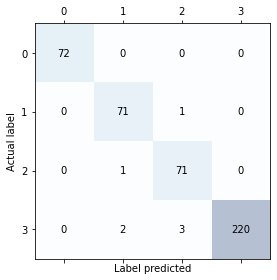

                            precision    recall  f1-score   support

    close to total failure       1.00      1.00      1.00        72
                severe lag       0.96      0.99      0.97        72
                 small lag       0.95      0.99      0.97        72
optimal switching behavior       1.00      0.98      0.99       225

                  accuracy                           0.98       441
                 macro avg       0.98      0.99      0.98       441
              weighted avg       0.98      0.98      0.98       441



In [63]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Label predicted')
plt.ylabel('Actual label')

plt.tight_layout()
plt.show()

# a classification report
target_names = ['close to total failure', 'severe lag', 'small lag', 'optimal switching behavior']
print(classification_report(y_test, y_pred, target_names=target_names))

In [64]:
# Logistis regression
pipe_lr = make_pipeline(StandardScaler(),   
                        PCA(n_components=2), 
                        LogisticRegression(solver = 'lbfgs', multi_class='auto', random_state=1)) 

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.506


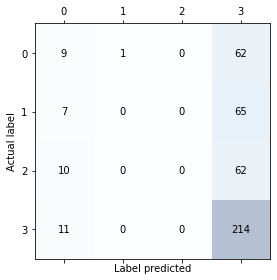

                            precision    recall  f1-score   support

    close to total failure       0.24      0.12      0.17        72
                severe lag       0.00      0.00      0.00        72
                 small lag       0.00      0.00      0.00        72
optimal switching behavior       0.53      0.95      0.68       225

                  accuracy                           0.51       441
                 macro avg       0.19      0.27      0.21       441
              weighted avg       0.31      0.51      0.37       441



C:\Users\hei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
# Poor model, confusion matrix to see
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Label predicted')
plt.ylabel('Actual label')

plt.tight_layout()
plt.show()

# a classification report
target_names = ['close to total failure', 'severe lag', 'small lag', 'optimal switching behavior']
print(classification_report(y_test, y_pred, target_names=target_names))

#### RandomSearch on RandomForest

In [28]:
forest_ = RandomForestClassifier(random_state = 1)

estim = [int(k) for k in np.linspace(start = 200, stop = 3000, num = 15)]
feat = ['auto', 'sqrt']

dpth = [int(l) for l in np.linspace(5, 145, num = 15)]
dpth.append(None)

split_min = [2, 4, 6, 8]
leaf_min = [1, 2, 3, 4]
bootstrap = [True, False]

# Create the random grid
params_rand = {'n_estimators': estim,
               'max_features': feat,
               'max_depth': dpth,
               'min_samples_split': split_min,
               'min_samples_leaf': leaf_min,
               'bootstrap': bootstrap}

randomRFC = RandomizedSearchCV(forest_, param_distributions=params_rand, 
                            n_iter=80, cv = 3, verbose = 1, 
                            n_jobs = -1)
best_randomRFC = randomRFC.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.3min finished


In [66]:
print(randomRFC.best_score_)
print(randomRFC.best_params_)

0.9665532879818595
{'n_estimators': 2600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 65, 'bootstrap': True}


#### Random Forest with best hyperparameters and optimized weights

In [83]:
#Random Forest
pipe_rfr = make_pipeline(RandomForestClassifier(n_estimators = 600, min_samples_split = 2, max_features = 'auto',
                                                max_depth = 45, bootstrap = False,random_state=1))


pipe_rfr.fit(X_train, y_train)
y_pred = pipe_rfr.predict(X_test)

print('Test Accuracy: %.3f' % pipe_rfr.score(X_test, y_test))
print("")

Test Accuracy: 0.986



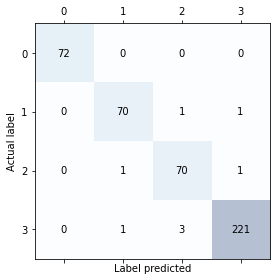

                            precision    recall  f1-score   support

    close to total failure       1.00      1.00      1.00        72
                severe lag       0.97      0.97      0.97        72
                 small lag       0.95      0.97      0.96        72
optimal switching behavior       0.99      0.98      0.99       225

                  accuracy                           0.98       441
                 macro avg       0.98      0.98      0.98       441
              weighted avg       0.98      0.98      0.98       441



In [68]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Label predicted')
plt.ylabel('Actual label')

plt.tight_layout()
plt.show()

# a classification report
target_names = ['close to total failure', 'severe lag', 'small lag', 'optimal switching behavior']
print(classification_report(y_test, y_pred, target_names=target_names))

### Bagging and boosting

In [69]:
# When max_depth is none, 
# nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None, # Checking with None, trying to overfit
                              random_state=1)

bag  = BaggingClassifier(base_estimator    = tree,
                        n_estimators       =   500,   # Number of classification models
                        max_samples        =   1.0,   # bootstrap proportion
                        max_features       =   1.0, 
                        bootstrap          =  True,   # with replacement
                        bootstrap_features = False,   # no bootstrap of features
                        n_jobs             =    -1, 
                        random_state       =     1)

In [70]:
# Fit a single tree
tree = tree.fit(X_train, y_train)

# Predict with the tree-model
y_train_pred = tree.predict(X_train)
y_test_pred  = tree.predict(X_test)

print(tree.get_params())
print("")

tree_train = accuracy_score(y_train, y_train_pred)
tree_test  = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies: %.3f/%.3f'
      % (tree_train, tree_test))

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 1, 'splitter': 'best'}

Decision tree train/test accuracies: 1.000/0.914


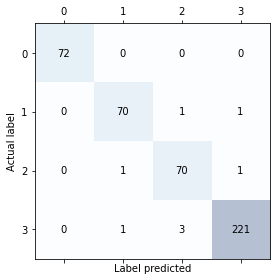

                            precision    recall  f1-score   support

    close to total failure       1.00      1.00      1.00        72
                severe lag       0.97      0.97      0.97        72
                 small lag       0.95      0.97      0.96        72
optimal switching behavior       0.99      0.98      0.99       225

                  accuracy                           0.98       441
                 macro avg       0.98      0.98      0.98       441
              weighted avg       0.98      0.98      0.98       441



In [71]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Label predicted')
plt.ylabel('Actual label')

plt.tight_layout()
plt.show()

# a classification report
target_names = ['close to total failure', 'severe lag', 'small lag', 'optimal switching behavior']
print(classification_report(y_test, y_pred, target_names=target_names))

In [72]:
# Fitting the 500 bootstrapped trees
bag = bag.fit(X_train, y_train)

# Predicting with the bag-model
y_train_pred = bag.predict(X_train)
y_test_pred  = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test  = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies: %.3f/%.3f'
      % (bag_train, bag_test))

Bagging train/test accuracies: 1.000/0.984


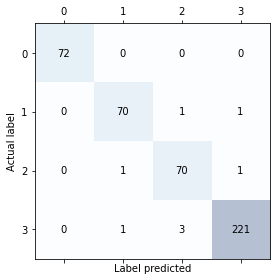

                            precision    recall  f1-score   support

    close to total failure       1.00      1.00      1.00        72
                severe lag       0.97      0.97      0.97        72
                 small lag       0.95      0.97      0.96        72
optimal switching behavior       0.99      0.98      0.99       225

                  accuracy                           0.98       441
                 macro avg       0.98      0.98      0.98       441
              weighted avg       0.98      0.98      0.98       441



In [73]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Label predicted')
plt.ylabel('Actual label')

plt.tight_layout()
plt.show()

# a classification report
target_names = ['close to total failure', 'severe lag', 'small lag', 'optimal switching behavior']
print(classification_report(y_test, y_pred, target_names=target_names))

#### AdaBoost with simple DecisionTree

In [74]:
ada = AdaBoostClassifier(base_estimator    = tree,
                         n_estimators      = 500,   # 500 repetitions, called m in the presentation
                         learning_rate     = 0.1,   # Shrinkage of the classifier contribution (alpha).
                                                    # This will affect the weighting of the samples.
                         random_state=1)

In [75]:
# Fit and test AdaBoost
ada          = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred  = ada.predict(X_test)


ada_train    = accuracy_score(y_train, y_train_pred) 
ada_test     = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'  % (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.916


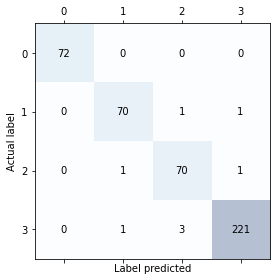

                            precision    recall  f1-score   support

    close to total failure       1.00      1.00      1.00        72
                severe lag       0.97      0.97      0.97        72
                 small lag       0.95      0.97      0.96        72
optimal switching behavior       0.99      0.98      0.99       225

                  accuracy                           0.98       441
                 macro avg       0.98      0.98      0.98       441
              weighted avg       0.98      0.98      0.98       441



In [76]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Label predicted')
plt.ylabel('Actual label')

plt.tight_layout()
plt.show()

# a classification report
target_names = ['close to total failure', 'severe lag', 'small lag', 'optimal switching behavior']
print(classification_report(y_test, y_pred, target_names=target_names))

#### AdaBoost with tweaked RandomForestClassifier

In [77]:
rfr_for_ada = RandomForestClassifier(n_estimators = 600, min_samples_split = 2, max_features = 'auto',
                                                max_depth = 45, bootstrap = False,random_state=1)

rfr_ada = AdaBoostClassifier(base_estimator    = rfr_for_ada,
                         n_estimators      = 500,   # 500 repetitions, called m in the presentation
                         learning_rate     = 0.1,   # Shrinkage of the classifier contribution (alpha).
                                                    # This will affect the weighting of the samples.
                         random_state=1)

rfr_ada = rfr_ada.fit(X_train, y_train)
y_train_pred = rfr_ada.predict(X_train)
y_test_pred  = rfr_ada.predict(X_test)


rfr_ada_train    = accuracy_score(y_train, y_train_pred) 
rfr_ada_test     = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'  % (rfr_ada_train, rfr_ada_test))

AdaBoost train/test accuracies 1.000/0.982


#### Testing AdaBoost for all target values

In [78]:
y = target.cooler_condition


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

rfr_ada = rfr_ada.fit(X_train, y_train)
y_train_pred = rfr_ada.predict(X_train)
y_test_pred  = rfr_ada.predict(X_test)


rfr_ada_train    = accuracy_score(y_train, y_train_pred) 
rfr_ada_test     = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'  % (rfr_ada_train, rfr_ada_test))

AdaBoost train/test accuracies 1.000/0.998


In [79]:
y = target.stable_flag

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

rfr_ada = rfr_ada.fit(X_train, y_train)
y_train_pred = rfr_ada.predict(X_train)
y_test_pred  = rfr_ada.predict(X_test)


rfr_ada_train    = accuracy_score(y_train, y_train_pred) 
rfr_ada_test     = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'  % (rfr_ada_train, rfr_ada_test))

AdaBoost train/test accuracies 1.000/0.975


In [80]:
y = target.internal_pump_leak

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

rfr_ada = rfr_ada.fit(X_train, y_train)
y_train_pred = rfr_ada.predict(X_train)
y_test_pred  = rfr_ada.predict(X_test)


rfr_ada_train    = accuracy_score(y_train, y_train_pred) 
rfr_ada_test     = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'  % (rfr_ada_train, rfr_ada_test))

AdaBoost train/test accuracies 1.000/0.998


In [81]:
y = target.hydraulic_accumulator

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

rfr_ada = rfr_ada.fit(X_train, y_train)
y_train_pred = rfr_ada.predict(X_train)
y_test_pred  = rfr_ada.predict(X_test)


rfr_ada_train    = accuracy_score(y_train, y_train_pred) 
rfr_ada_test     = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'  % (rfr_ada_train, rfr_ada_test))

AdaBoost train/test accuracies 1.000/0.984
